In [10]:
import pandas as pd
import os
from canopywatch.ml_logic.preprocessor import image_preprocessing_bulk, image_preprocessing, create_full_filepath, mask_preprocessing, mask_preprocessing_bulk
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Load data and preprocess it

In [11]:
data_path = '../data/Forest Segmented/Forest Segmented/meta_data.csv'
data = pd.read_csv(data_path)
data

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg
...,...,...
5103,998002_sat_31.jpg,998002_mask_31.jpg
5104,998002_sat_32.jpg,998002_mask_32.jpg
5105,998002_sat_40.jpg,998002_mask_40.jpg
5106,998002_sat_41.jpg,998002_mask_41.jpg


In [12]:
images_path = '../data/Forest Segmented/Forest Segmented/images'
masks_path = '../data/Forest Segmented/Forest Segmented/masks'

In [13]:
sample_1000 = data.head(1000)
file_paths_image, file_paths_mask = create_full_filepath(sample_1000,images_path=images_path,masks_path=masks_path)

/Users/eleonoredemarnhac/code/eleonoredmc/canopy_watch/canopywatch/ml_logic/preprocessor.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['image'] = images_path + '/' + data['image']
/Users/eleonoredemarnhac/code/eleonoredmc/canopy_watch/canopywatch/ml_logic/preprocessor.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mask'] = masks_path + '/' + data['mask']


In [14]:
#apply preprocessing_bulk on these list to ensure perfect matching between image and mask
X = image_preprocessing_bulk(file_paths_image)
y = mask_preprocessing_bulk(file_paths_mask)


In [15]:
print(X.shape)
print(y.shape)

(1000, 256, 256, 3)
(1000, 256, 256, 1)


# Create model

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

#Encoder function
def build_encoder(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()

    encoder.add(Conv2D(8, (2,2), input_shape=(256, 256, 3), activation='relu'))
    encoder.add(MaxPooling2D(2,2))

    encoder.add(Conv2D(16, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2,2))

    encoder.add(Conv2D(32, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2,2))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))

    return encoder

In [18]:
encoder = build_encoder(392)
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 16)      528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0

In [19]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

#build decoder function
def build_decoder(latent_dimension):
    decoder = Sequential()

    decoder.add(Dense(32*32*3, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((32,32,3)))
    decoder.add(Conv2DTranspose(16, (2, 2), strides=2, padding='same', activation='relu'))

    decoder.add(Conv2DTranspose(8, (2, 2), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(1, (2, 2), strides=2, padding='same', activation='relu'))
    return decoder

In [20]:
decoder = build_decoder(392)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3072)              1207296   
                                                                 
 reshape (Reshape)           (None, 32, 32, 3)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 16)       208       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 8)      520       
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 256, 256, 1)      33        
 ranspose)                                                       
                                                      

In [21]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

def build_autoencoder(encoder, decoder):
    inp = Input((256, 256,3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

In [22]:
autoencoder = build_autoencoder(encoder, decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 392)               12057888  
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 1)       1208057   
                                                                 
Total params: 13,265,945
Trainable params: 13,265,945
Non-trainable params: 0
_________________________________________________________________


In [23]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='binary_crossentropy',
                  optimizer='adam')

In [24]:
compile_autoencoder(autoencoder)

In [25]:
autoencoder.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10


2024-11-27 10:47:38.420241: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - 4s 131ms/step - loss: 5.4598
Epoch 2/10
25/25 [==============================] - 3s 140ms/step - loss: 4.1394
Epoch 3/10
25/25 [==============================] - 3s 126ms/step - loss: 2.9216
Epoch 4/10
25/25 [==============================] - 4s 140ms/step - loss: 2.0836
Epoch 5/10
25/25 [==============================] - 3s 138ms/step - loss: 1.7681
Epoch 6/10
25/25 [==============================] - 3s 130ms/step - loss: 1.6276
Epoch 7/10
25/25 [==============================] - 3s 132ms/step - loss: 1.4872
Epoch 8/10
25/25 [==============================] - 3s 136ms/step - loss: 1.3695
Epoch 9/10
25/25 [==============================] - 3s 136ms/step - loss: 1.2670
Epoch 10/10
25/25 [==============================] - 3s 128ms/step - loss: 1.1738


In [26]:
X_test[10].shape

(256, 256, 3)

In [27]:
test_predict = np.expand_dims(X_test[10], axis=0)
test_predict.shape

(1, 256, 256, 3)

In [28]:
prediction = autoencoder.predict(test_predict)

prediction

1/1 [==============================] - 0s 116ms/step


array([[[[0.12423122],
         [0.05043759],
         [0.18412209],
         ...,
         [0.24800868],
         [0.49779314],
         [0.17738527]],

        [[0.08473225],
         [0.05874544],
         [0.        ],
         ...,
         [0.18035518],
         [0.21965665],
         [0.21266101]],

        [[0.38505793],
         [0.20337662],
         [0.35175866],
         ...,
         [0.16844499],
         [0.4221945 ],
         [0.17027426]],

        ...,

        [[0.15972921],
         [0.13200903],
         [0.18115053],
         ...,
         [0.12689964],
         [0.1207063 ],
         [0.14239775]],

        [[0.2849052 ],
         [0.18149789],
         [0.4007302 ],
         ...,
         [0.20565309],
         [0.3925694 ],
         [0.16489649]],

        [[0.17757034],
         [0.06984651],
         [0.16931109],
         ...,
         [0.12987156],
         [0.15188856],
         [0.16194013]]]], dtype=float32)

In [29]:
prediction.shape

(1, 256, 256, 1)

In [33]:
prediction = prediction.reshape(256,256,1)

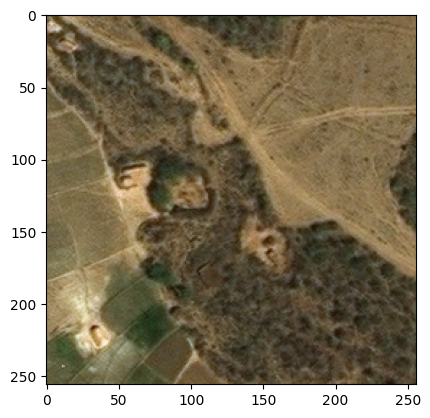

In [30]:
plt.imshow(X_test[10])

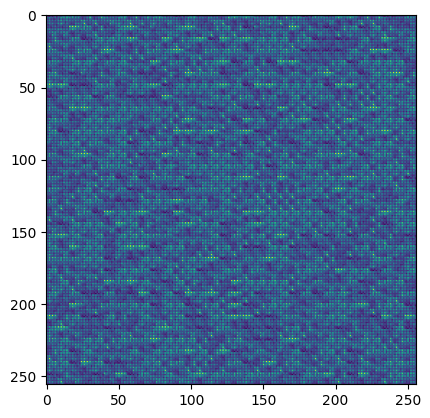

In [34]:
plt.imshow(prediction)

In [35]:
error = autoencoder.evaluate(X_test, y_test)
error

7/7 [==============================] - 1s 43ms/step - loss: 1.1714


1.1713947057724